## Hypothesis testing 1:

### Objective
Testing whether or not the global temperater has risen between 1960 and 2010 by testing multiple hypotheses.

### Method
We will test whether global temparatures have risen by comparing average temparatures in 2010 against past five data points (10-year increments between 1960 and 2000 - i.e. 1960,1970, 1980, 1990, and 2000)

* H0 (Null) - Global temperatures are stable since $Ti$
* Ha (alternate) - Global Temperatures are rising on average since $Ti$ . Forbes article (https://www.forbes.com/sites/peterferrara/2012/05/31/sorry-global-warming-alarmists-the-earth-is-cooling/#7e44f66f3de0)

, where $Ti$ is average temparatures in one of the 10-year increments between 1960 and 2000


* dataset1 = average temperatures $Ti$
* dataset2 = average temperatures 2010


* H0 = Mean (dataset 2) - Mean (dataset 1) = 0
* Ha = Mean (dataset 2) - Mean (dataset 1) >= 0


### Load packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [109]:
from scipy.stats import ttest_rel
from statsmodels.stats import multitest

### Load and transform datasets

In [48]:
# load dataset containing smoothed average temperatures
df = pd.read_csv('../data/ewma.csv', header=0, parse_dates=[0], squeeze=True)
df.ewma = pd.to_numeric(df.ewma)
temp_col = 'ewma'

In [87]:
# get temperature of countries in $Ti$
list_years = list(range(1960, 2010 + 1, 10))
dfs = {'df_' + str(i):df[df.Year == i].reset_index()[temp_col] for i in list_years}

In [65]:
# get describtive statistics
df[df.Year.isin(list_years)] \
    .loc[:, ['Country','Year', temp_col]] \
    .pivot(index='Country', columns='Year', values=temp_col) \
    .describe()

Year,1960,1970,1980,1990,2000,2010
count,175.000000,175.000000,175.000000,175.000000,175.000000,175.000000
mean,18.757030,18.610345,18.659249,18.897393,19.144096,19.406476
std,8.688498,8.820747,8.813507,8.701576,8.636002,8.625668
min,-16.951083,-17.924556,-17.851244,-18.054064,-17.477080,-16.400799
25%,11.493042,11.346447,11.215653,11.792331,12.183069,12.274578
50%,22.151333,22.226821,22.102101,22.253692,22.542708,22.515152
75%,26.113375,26.016174,26.053031,26.188096,26.357701,26.634787
max,28.701167,28.809567,29.009296,29.054247,29.372047,29.669428


### Visualization

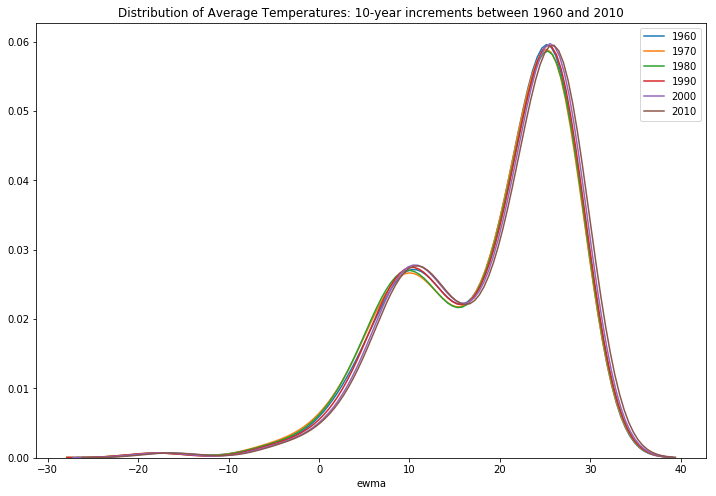

In [66]:
# compare distribution of temperatures in 10-year increments between 1960 and 2010
plt.figure(figsize=(12,8))
plt.title('Distribution of Average Temperatures: 10-year increments between 1960 and 2010')
for i in list_years:
    df_name = 'df_' + str(i)
    sns.distplot(dfs[df_name], hist=False, label=str(i))

From a quick visual inspection of the chart above, there are a few interesting points. First, in 1990 and 2000, there are more countries with a average temparature between 10 and 10 while less countries with a temparature between -10 and 10. This suggests temperatures have risen among countries with a lower temperature. Also, in 2010, the entire distribution has slightly shifted to the right (i.e. higher temperatures).

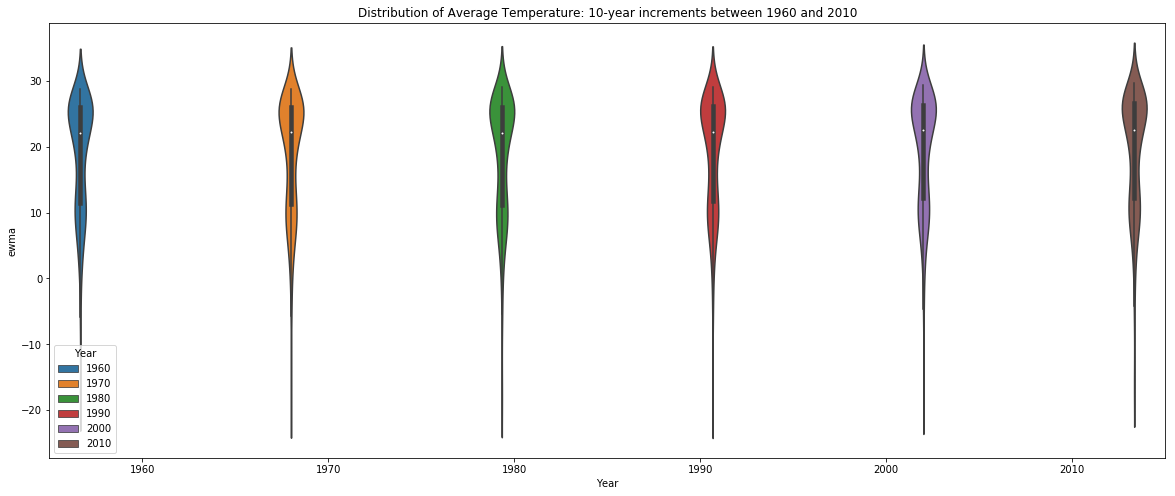

In [67]:
# compare distribution of temperatures in 1990 and 2010
plt.figure(figsize=(20,8))
plt.title('Distribution of Average Temperature: 10-year increments between 1960 and 2010')
df_violin = df[df.Year.isin(list_years)].loc[:,['Year', temp_col]]
sns.violinplot(x='Year', y=temp_col, hue='Year', data=df_violin);

It's hard to see, but again, the entire distribution has slightly shifted to the right in 2010. Let's test if that is the case.

### Hypothesis Test

In [ ]:
# perform multiple paired t-test

list_years_short = list_years[:-1]

list_pvalue = []
list_stats = []

for i in list_years_short:
    df_past = 'df_' + str(i)
    test_result = ttest_rel(dfs['df_2010'], dfs[df_past])
    list_pvalue.append(test_result.pvalue)
    list_stats.append(test_result.statistic)

df_result = pd.DataFrame({'Year':list_years_short, 'stats':list_stats, 'pvalue':list_pvalue})

We need to adjust the p-values because, as we learned from one of the lectures, we can be almost certain we would find something unusual just by chance if we test sufficiently many time. I will perform Bonferroni correction and compute false discovery rate (FDR) and use adjusted p-values to avoid false rejections.

In [113]:
# Bonferroni correction
bf_result = multitest.multipletests(df_result.pvalue, alpha=0.05, method='bonferroni')
bf_pvalue = bf_result[0]
bf_stats = bf_result[1]

In [115]:
# false discovery rate
fdr_result = multitest.multipletests(df_result.pvalue, alpha=0.05, method='fdr_bh')
fdr_pvalue = fdr_result[0]
fdr_stats = fdr_result[1]

In [118]:
# combine results
df_result['bf_pvalue'] = bf_pvalue
df_result['bf_stats'] = bf_stats
df_result['fdr_pvalue'] = fdr_pvalue
df_result['fdr_stats'] = fdr_stats

In [120]:
df_result.set_index('Year')

,pvalue,stats,bf_pvalue,bf_stats,fdr_pvalue,fdr_stats
Year,,,,,,
1960,3.396808e-59,24.877221,True,1.698404e-58,True,4.246010e-59
1970,1.952404e-78,33.831306,True,9.762021e-78,True,9.762021e-78
1980,2.411251e-76,32.765959,True,1.205625e-75,True,6.028127e-76
1990,5.835738e-60,25.200531,True,2.917869e-59,True,9.726230e-60
2000,7.815594e-43,18.457689,True,3.907797e-42,True,7.815594e-43


** FINDINGS: **
* All the p-values are significantly less than 0.025 and null hypothesis that average temperatures are stable is rejected.
* All the z-statistics are positive, which indicates that global Temperatures have risen in 2010 when compared to 1960, 1970, 1980, 1990 and 2000.